# Water table over a multistep impervious base

This is after a problem discussed in an article in Groundwater by Zaidel (https://doi.org/10.1111/gwat.12019):

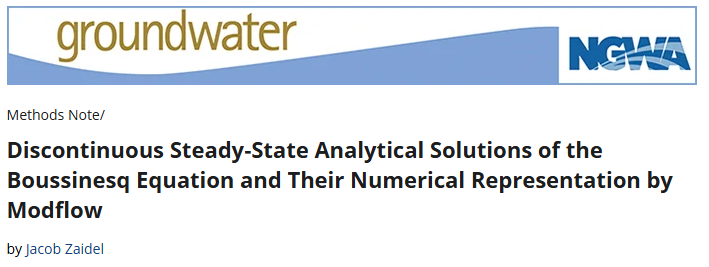

The Zaidel (2013) paper demonstrates that groundwater flow over a stepped impervious base 
presents significant numerical challenges for MODFLOW. The problem involves an unconfined 
aquifer with abrupt elevation changes in the basal surface, creating a discontinuous 
water table configuration.

Key findings from the paper:

1. **Convergence Issues**: Standard MODFLOW versions (2000, 2005) experienced significant 
    convergence problems when simulating flow over stepped geometries, sometimes failing 
    completely or producing erroneous results.

2. **Drying-Rewetting Challenges**: The transition between saturated and unsaturated 
    conditions at the step boundaries creates numerical instabilities, particularly in 
    thin unconfined aquifers.

3. **Solver Sensitivity**: The paper highlights how solver choice and settings critically 
    impact the ability to successfully simulate these geometries. Different iterative 
    solvers and convergence criteria yield varying degrees of success.

4. **Newton-Raphson Formulation**: Advanced solution schemes like the Newton-Raphson 
    method can improve convergence for these nonlinear problems, though careful selection 
    of solver parameters remains important.

Figure that sketches the problem at hand:

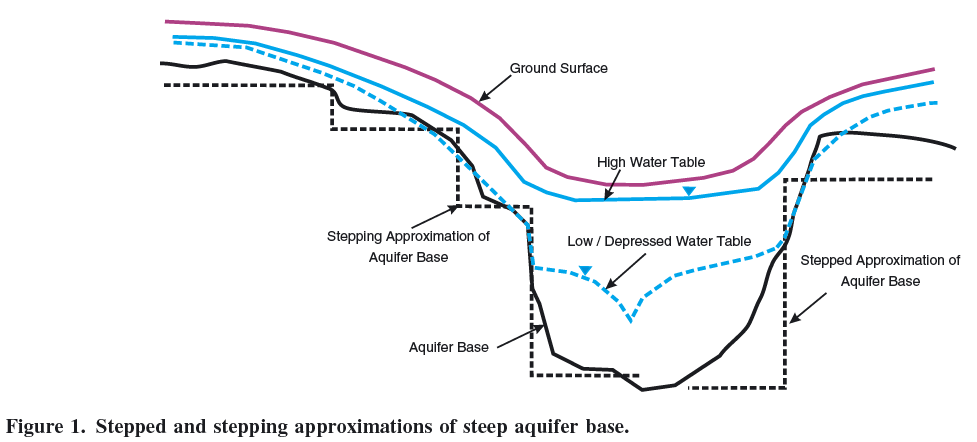

This notebook uses the stepping approximation of the base and explores how different 
MODFLOW 6 settings (confined vs. unconfined, Newton formulation, solver types) affect
convergence behavior and solution quality. But we will start with basic confined flow
and build up from there, tweaking the solver settings and interpreting the output as we go.

## Import packages
Let's start by importing the required packages for building the model and displaying results

In [1]:
import flopy
import numpy as np
import shutil

from zaidel_utils import plot_results, hclose

Give the simulation a name. It will also be the working directory for all the scenarios below that will be cleared whenever a new scenario is run.

In [2]:
sim_name = "zaidel"

The model represents a 1D cross-section (single row) with 100 columns
Each column is 5 meters wide, creating a 500-meter long profile

In [3]:

# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 100  # Number of columns
delr = 5.0  # Column width
delc = 1.0  # Row width
top = np.zeros(ncol, dtype=float) + 25.0  # Top of the model
k11 = 0.0001  # Horizontal hydraulic conductivity

Set the starting head. Note that we start with largely saturated cells and the water will consequently drain through the boundary.

In [4]:
strt = 23.0  # Starting head

Boundary stress period data for the CHD package

In [5]:
H1 = 23.0  # Constant head in column 1
H2 = 1.0 # Constant head in column <ncol>

# stress period data for CHD
chd_spd = [
        [0, 0, 0, H1],
        [0, 0, ncol - 1, H2],
    ]


We'll use confined flow initially, then progress to unconfined conditions

In [6]:
# Cell conversion type
icelltype = 0

In [7]:
# Initial bottom at zero
botm = np.zeros((nlay, nrow, ncol), dtype=float)

# Time discretization
tdis_ds = ((1.0, 1, 1.0),)

In [8]:
# setup simulation
sim_ws = sim_name
sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

Create the Iterative Model Solution (IMS) package with rather nominal settings. 
Note that we have `print_option=all` and store the iteration results in `ims.csv`

In [9]:
nouter = 100
ninner = 50
rclose = 1e-6
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="all",
    linear_acceleration="cg",
    outer_maximum=nouter,
    outer_dvclose=hclose,
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=f"{rclose}",
    csv_inner_output_filerecord="ims.csv",
)

Set up the basic groundwater flow model

In [10]:
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, newtonoptions="")
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=icelltype,
    k=k11,
    save_flows=True,
    save_specific_discharge=True,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)

Add the output control package for heads and budget

In [11]:
head_filerecord = f"{sim_name}.hds"
budget_filerecord = f"{sim_name}.cbc"
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

Next is a utility function to clean up the working directory, write the (updated) simulation to disk, and run (yes, yes, this violates the Single Responsibility Principle, sorry...)

In [12]:
def save_and_run(sim):
    # save
    shutil.rmtree(sim.sim_path)
    sim.write_simulation(silent=True)

    # run
    result, _ = sim.run_simulation(silent=True)
    if not result:
        print("run failed...")
        return False
    else:
        print("run succeeded...")
        return True

And one more routine to create a plot showing a cross-section of model results as well as the convergence behavior of the numerical solution

run succeeded...


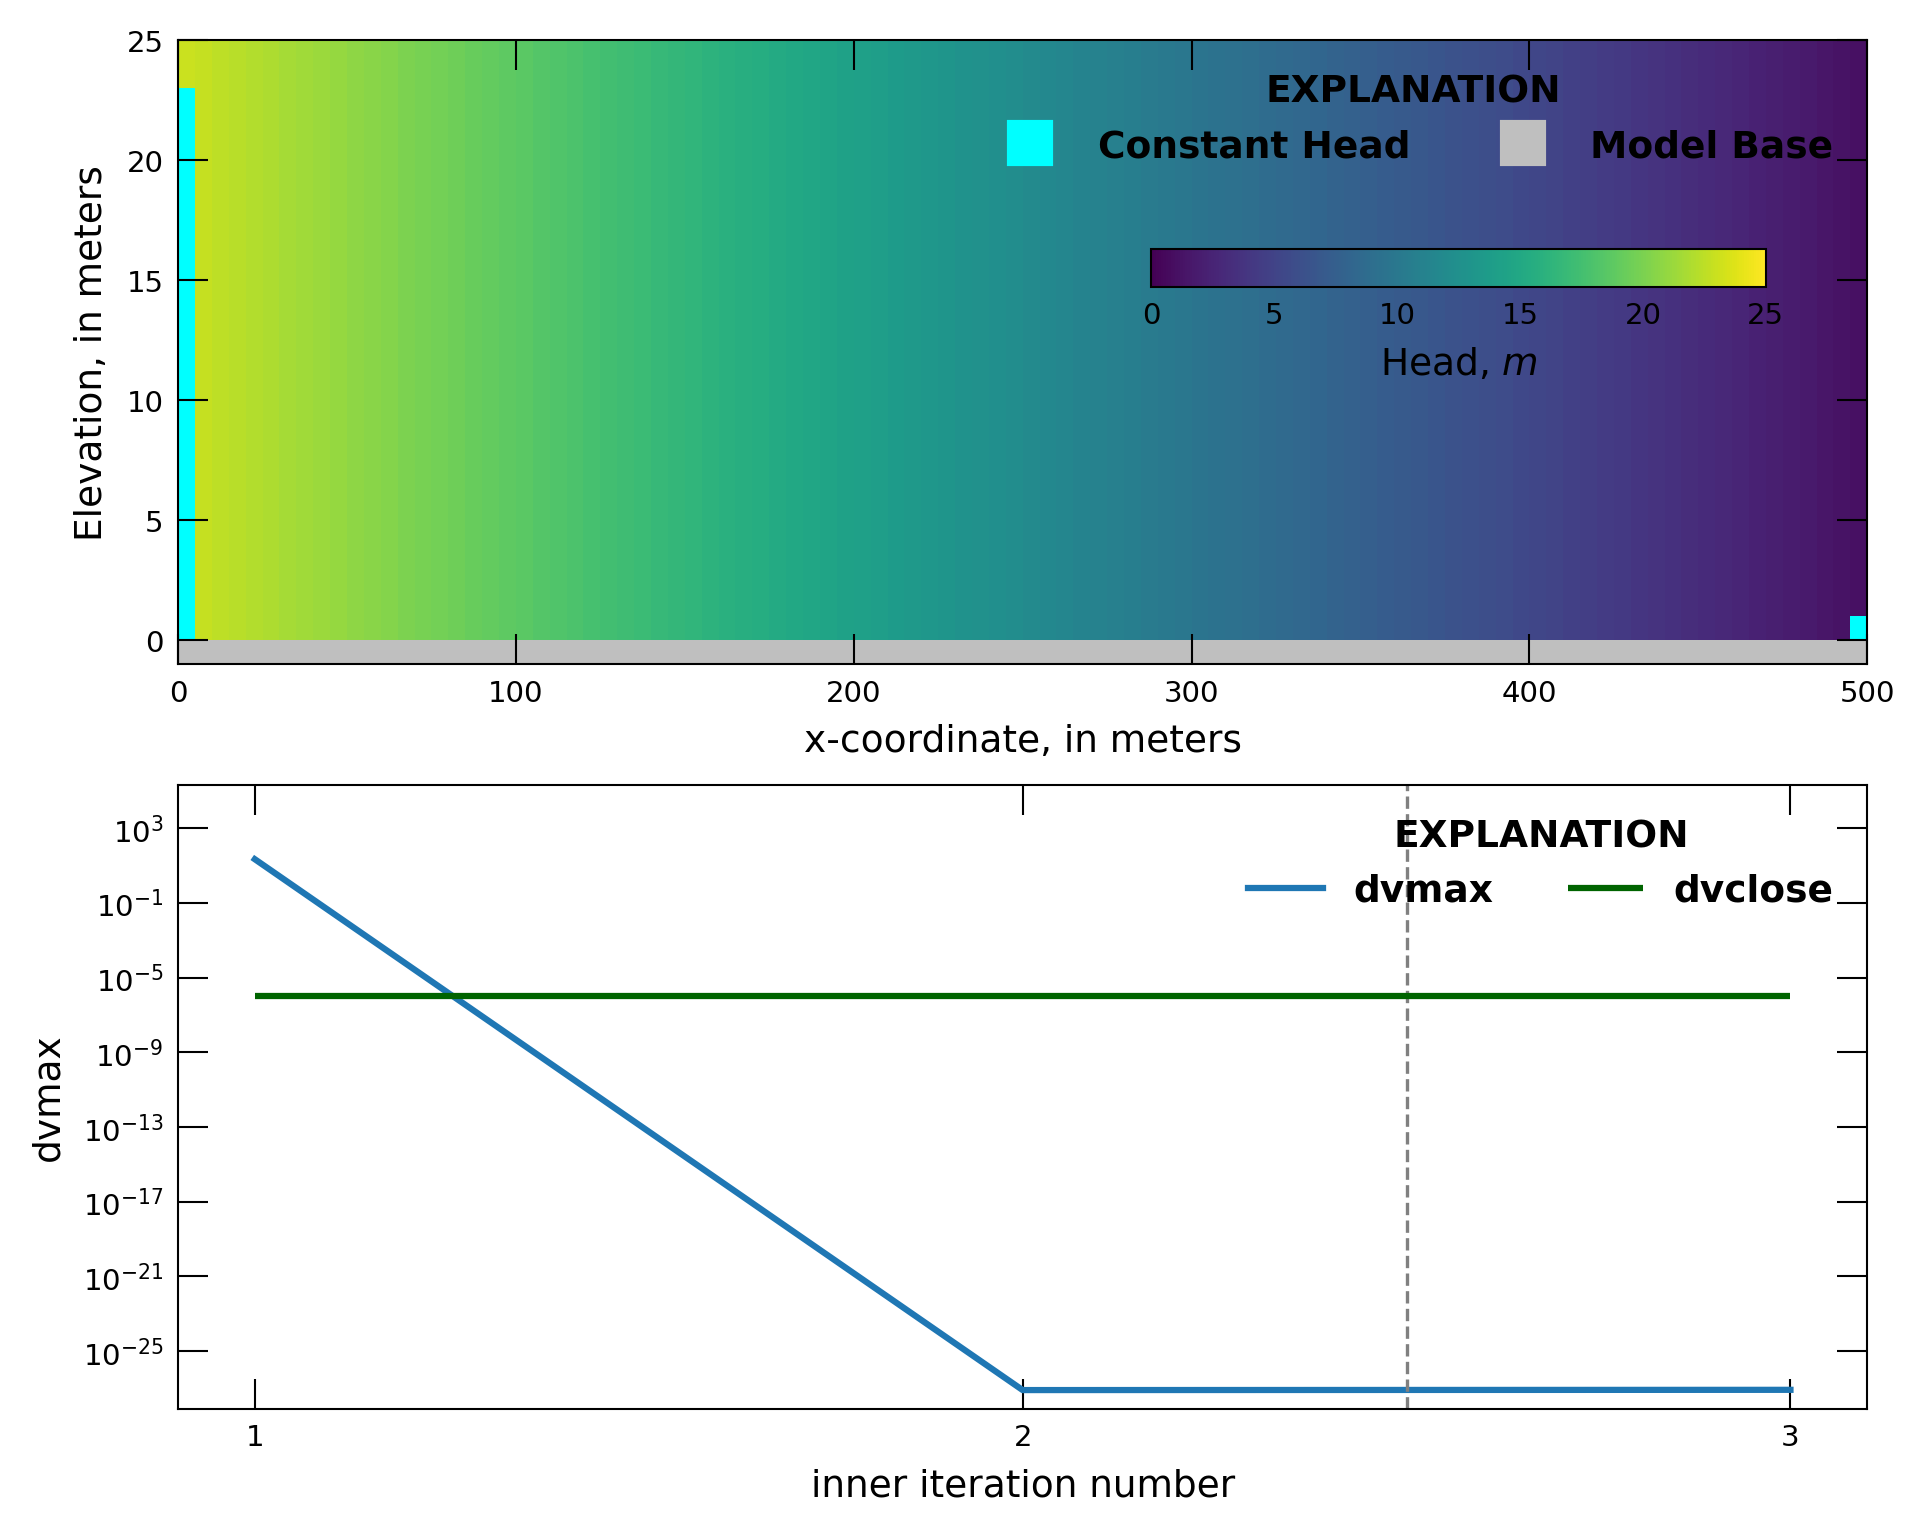

In [13]:
success = save_and_run(sim)
if success:
    plot_results(sim)

In [14]:
# add staircase bottom
dis = sim.get_model().get_package("DIS")
nsteps = 5
for j in range(ncol):
    dis.botm[:, :, j] = 20.0 - 5.0 * (nsteps*j//ncol)

run succeeded...


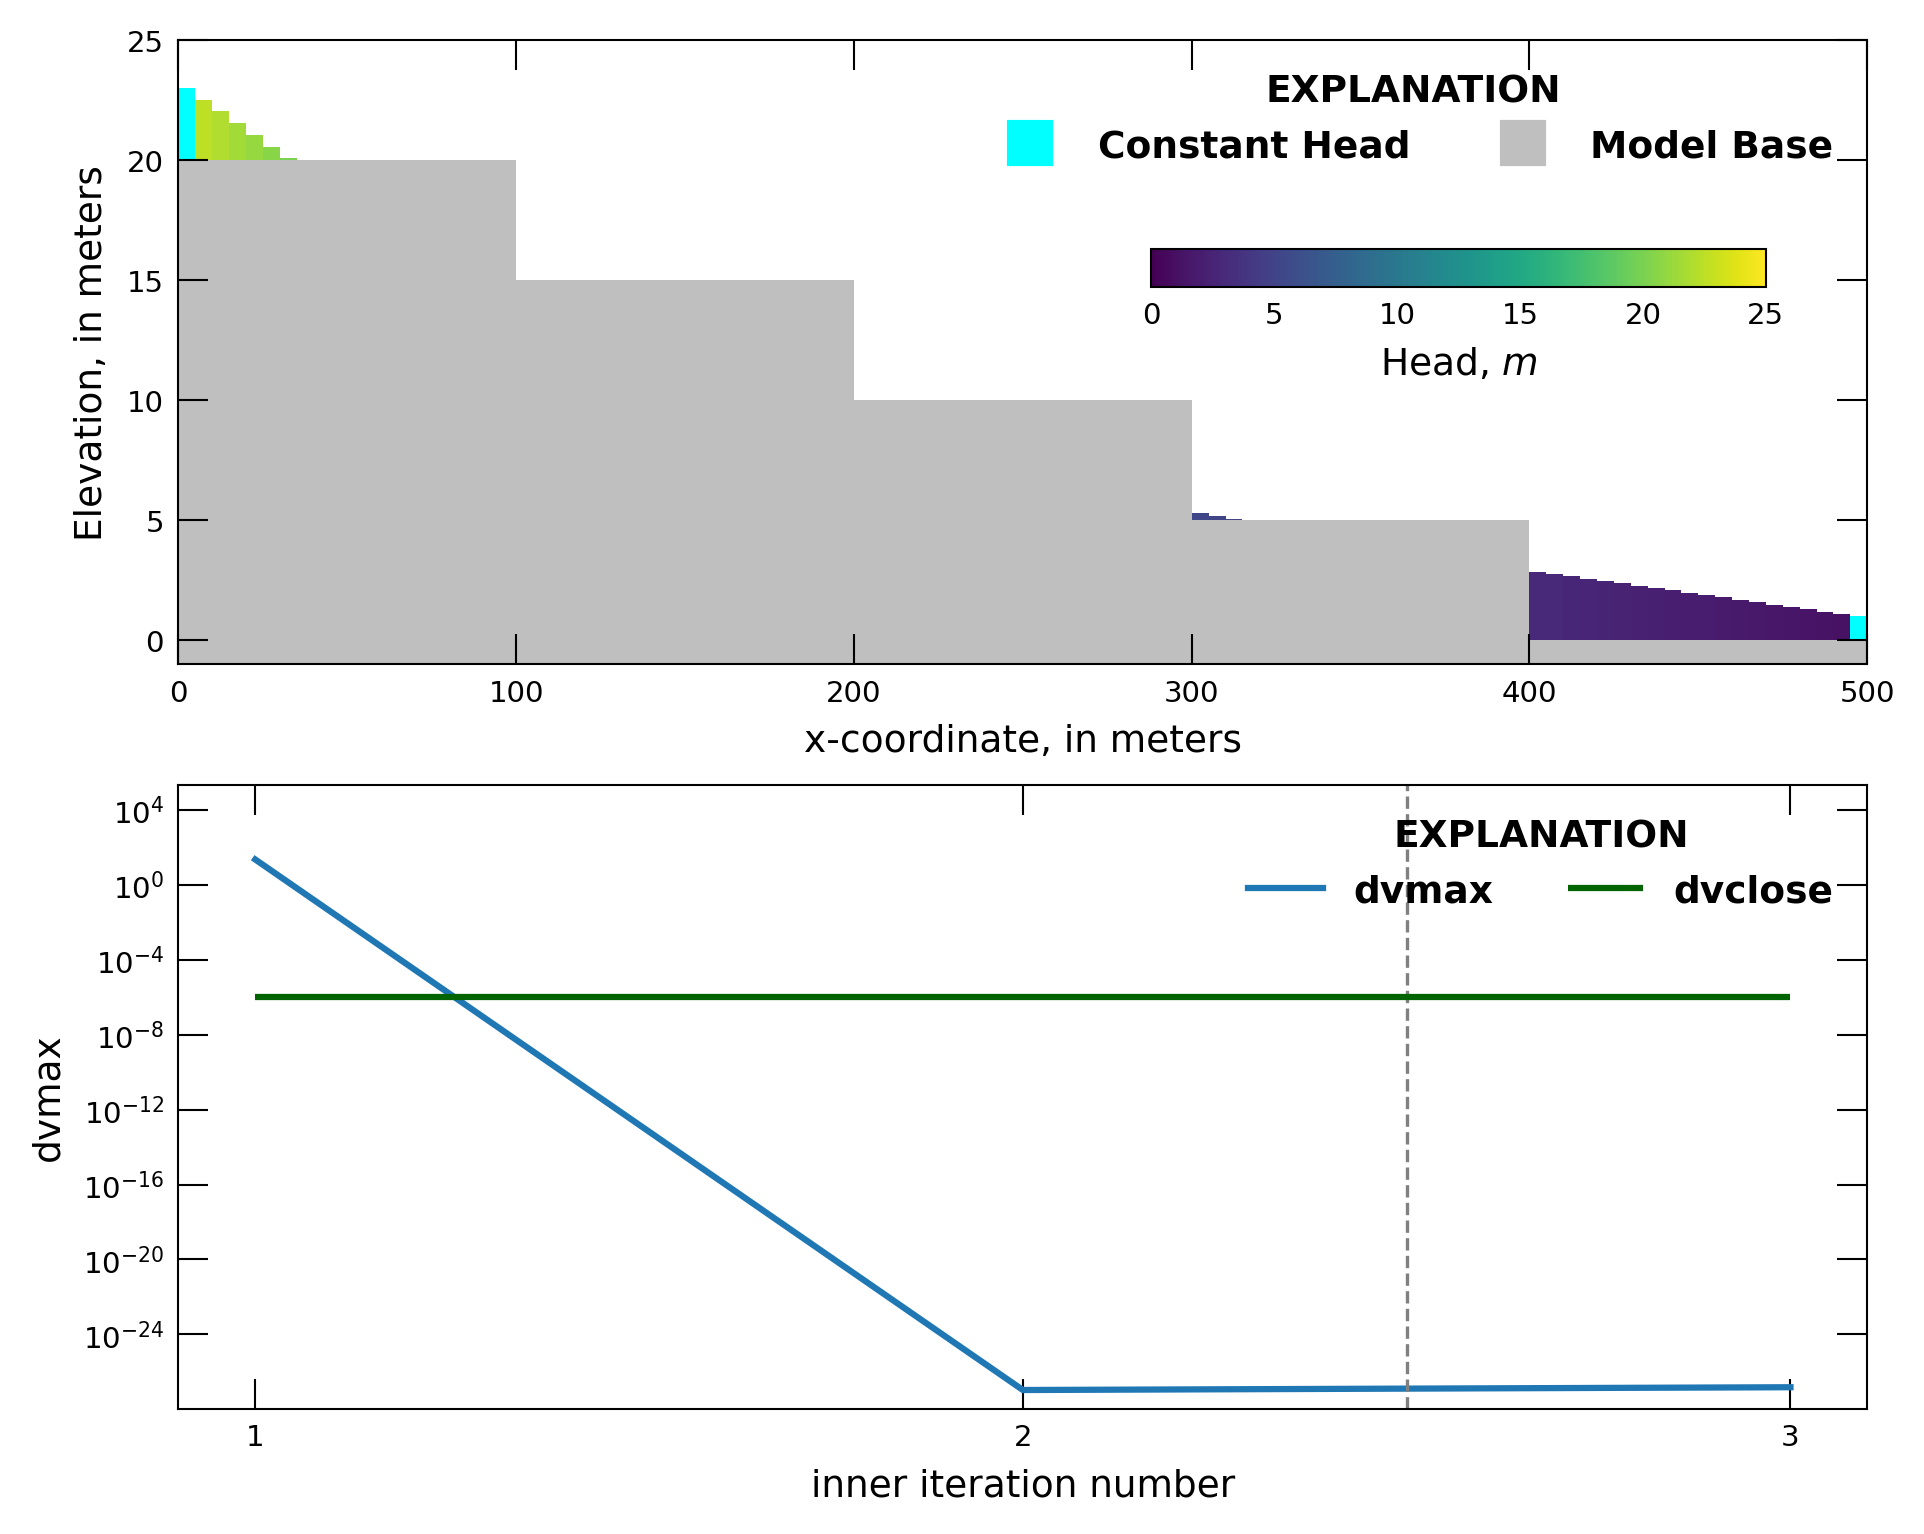

In [15]:
success = save_and_run(sim)
if success:
    plot_results(sim, False)

In [16]:
# run unconfined
sim.get_model().npf.icelltype = 1

run succeeded...


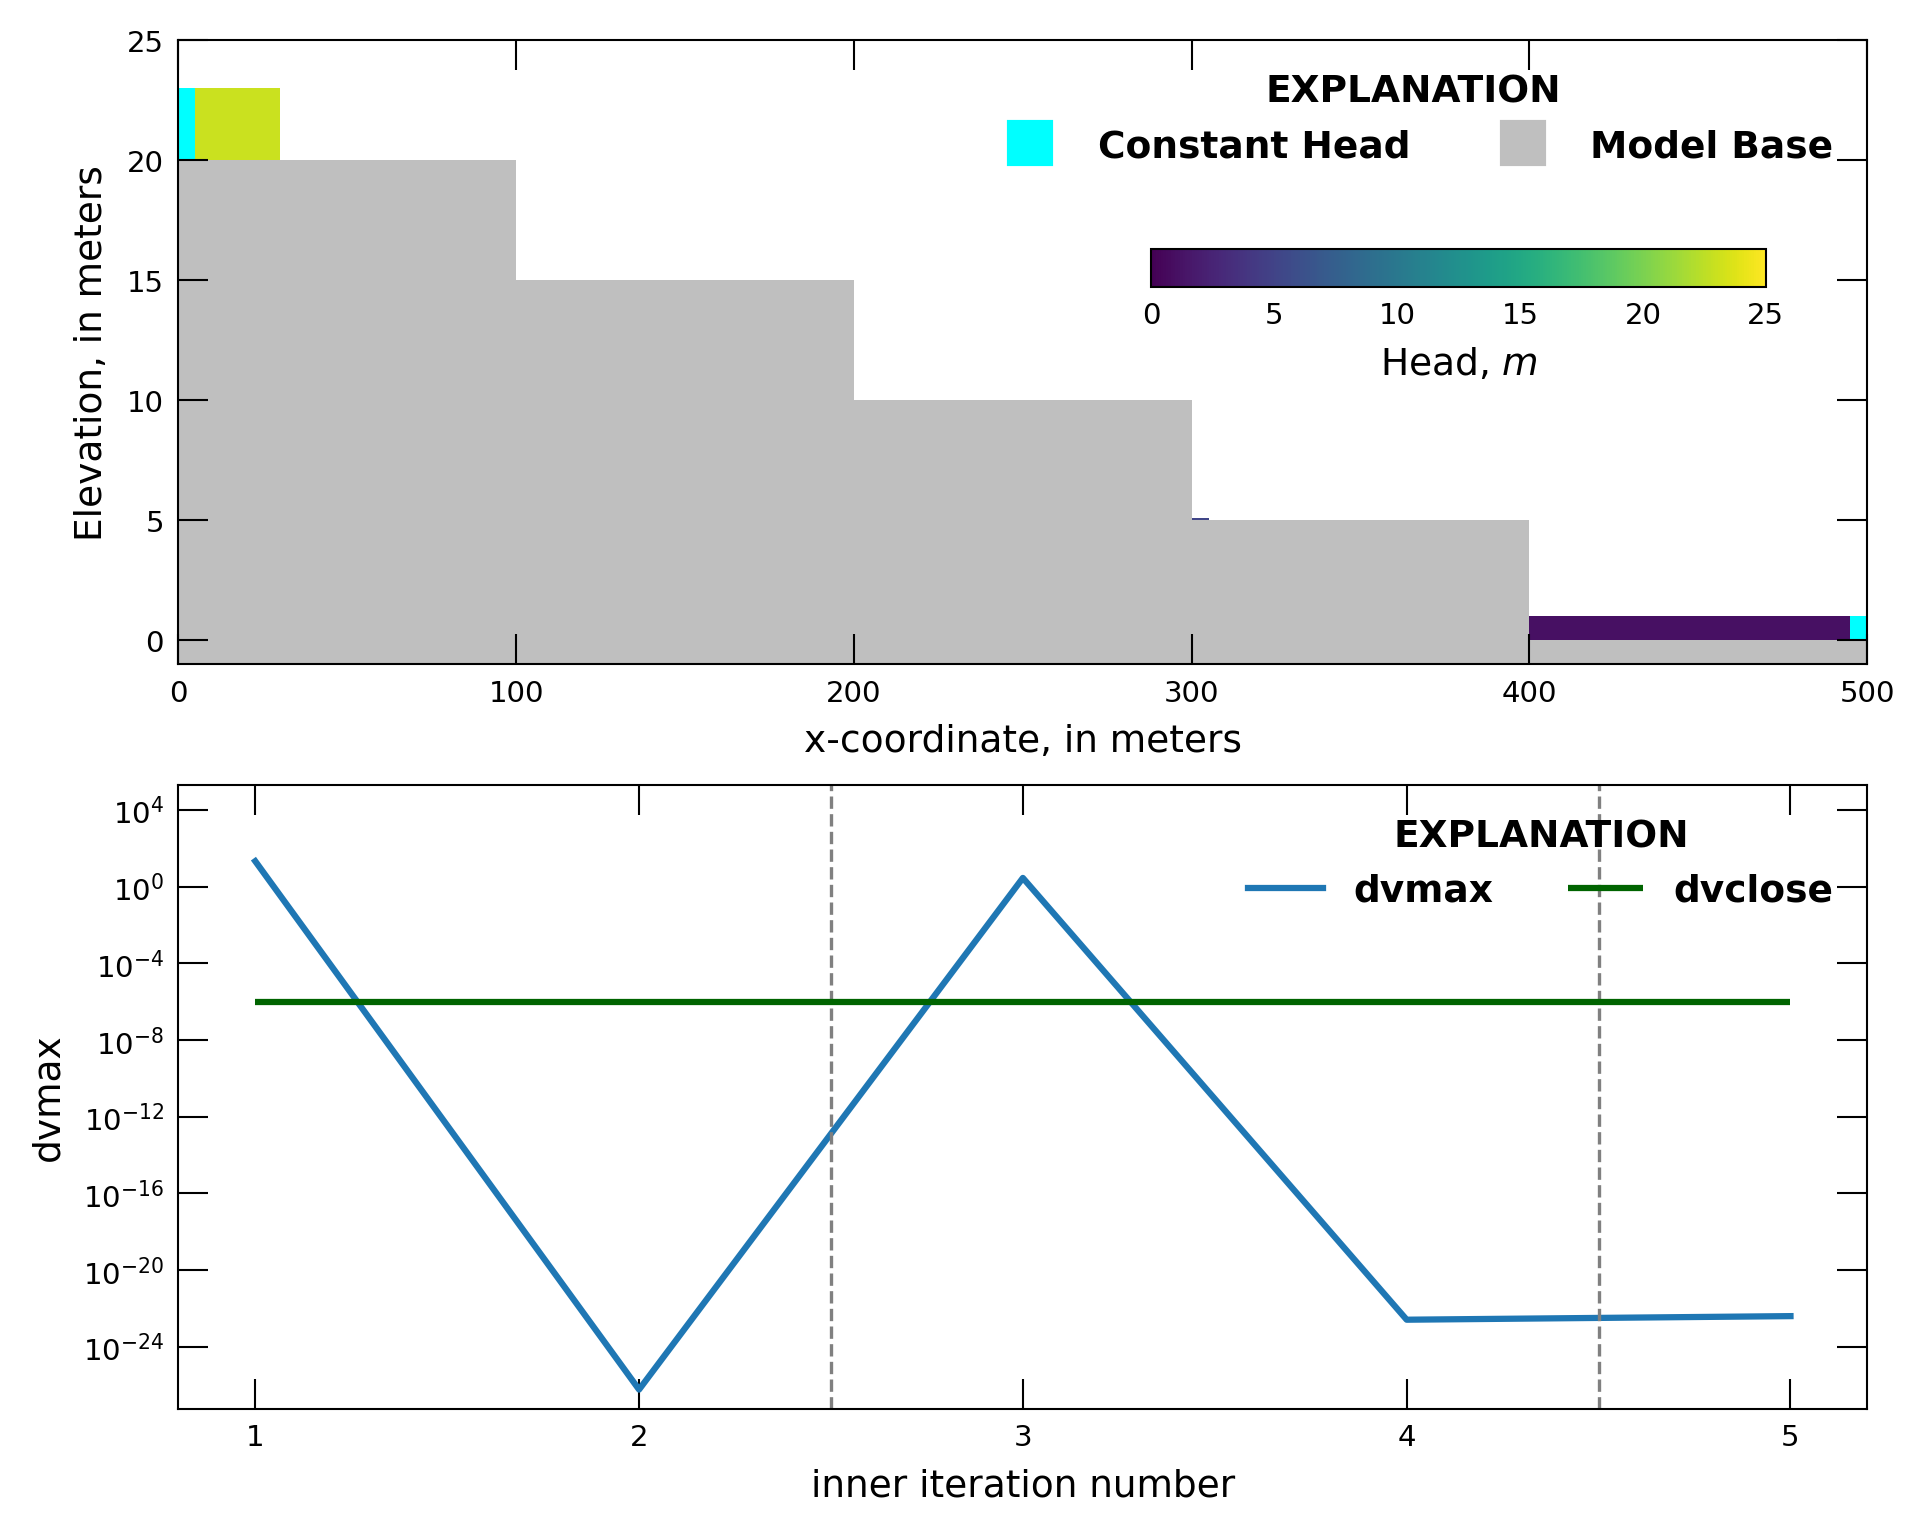

In [17]:
success = save_and_run(sim)
if success:
    plot_results(sim, False)

In [18]:
# activate newton formulation
sim.get_model().newtonoptions = "newton"

In [19]:
success = save_and_run(sim)
if success:
    plot_results(sim, False)

run failed...


In [20]:
# set complexity to complex (and unset CG)
sim.ims.linear_acceleration = None
sim.ims.complexity = "complex"

run succeeded...


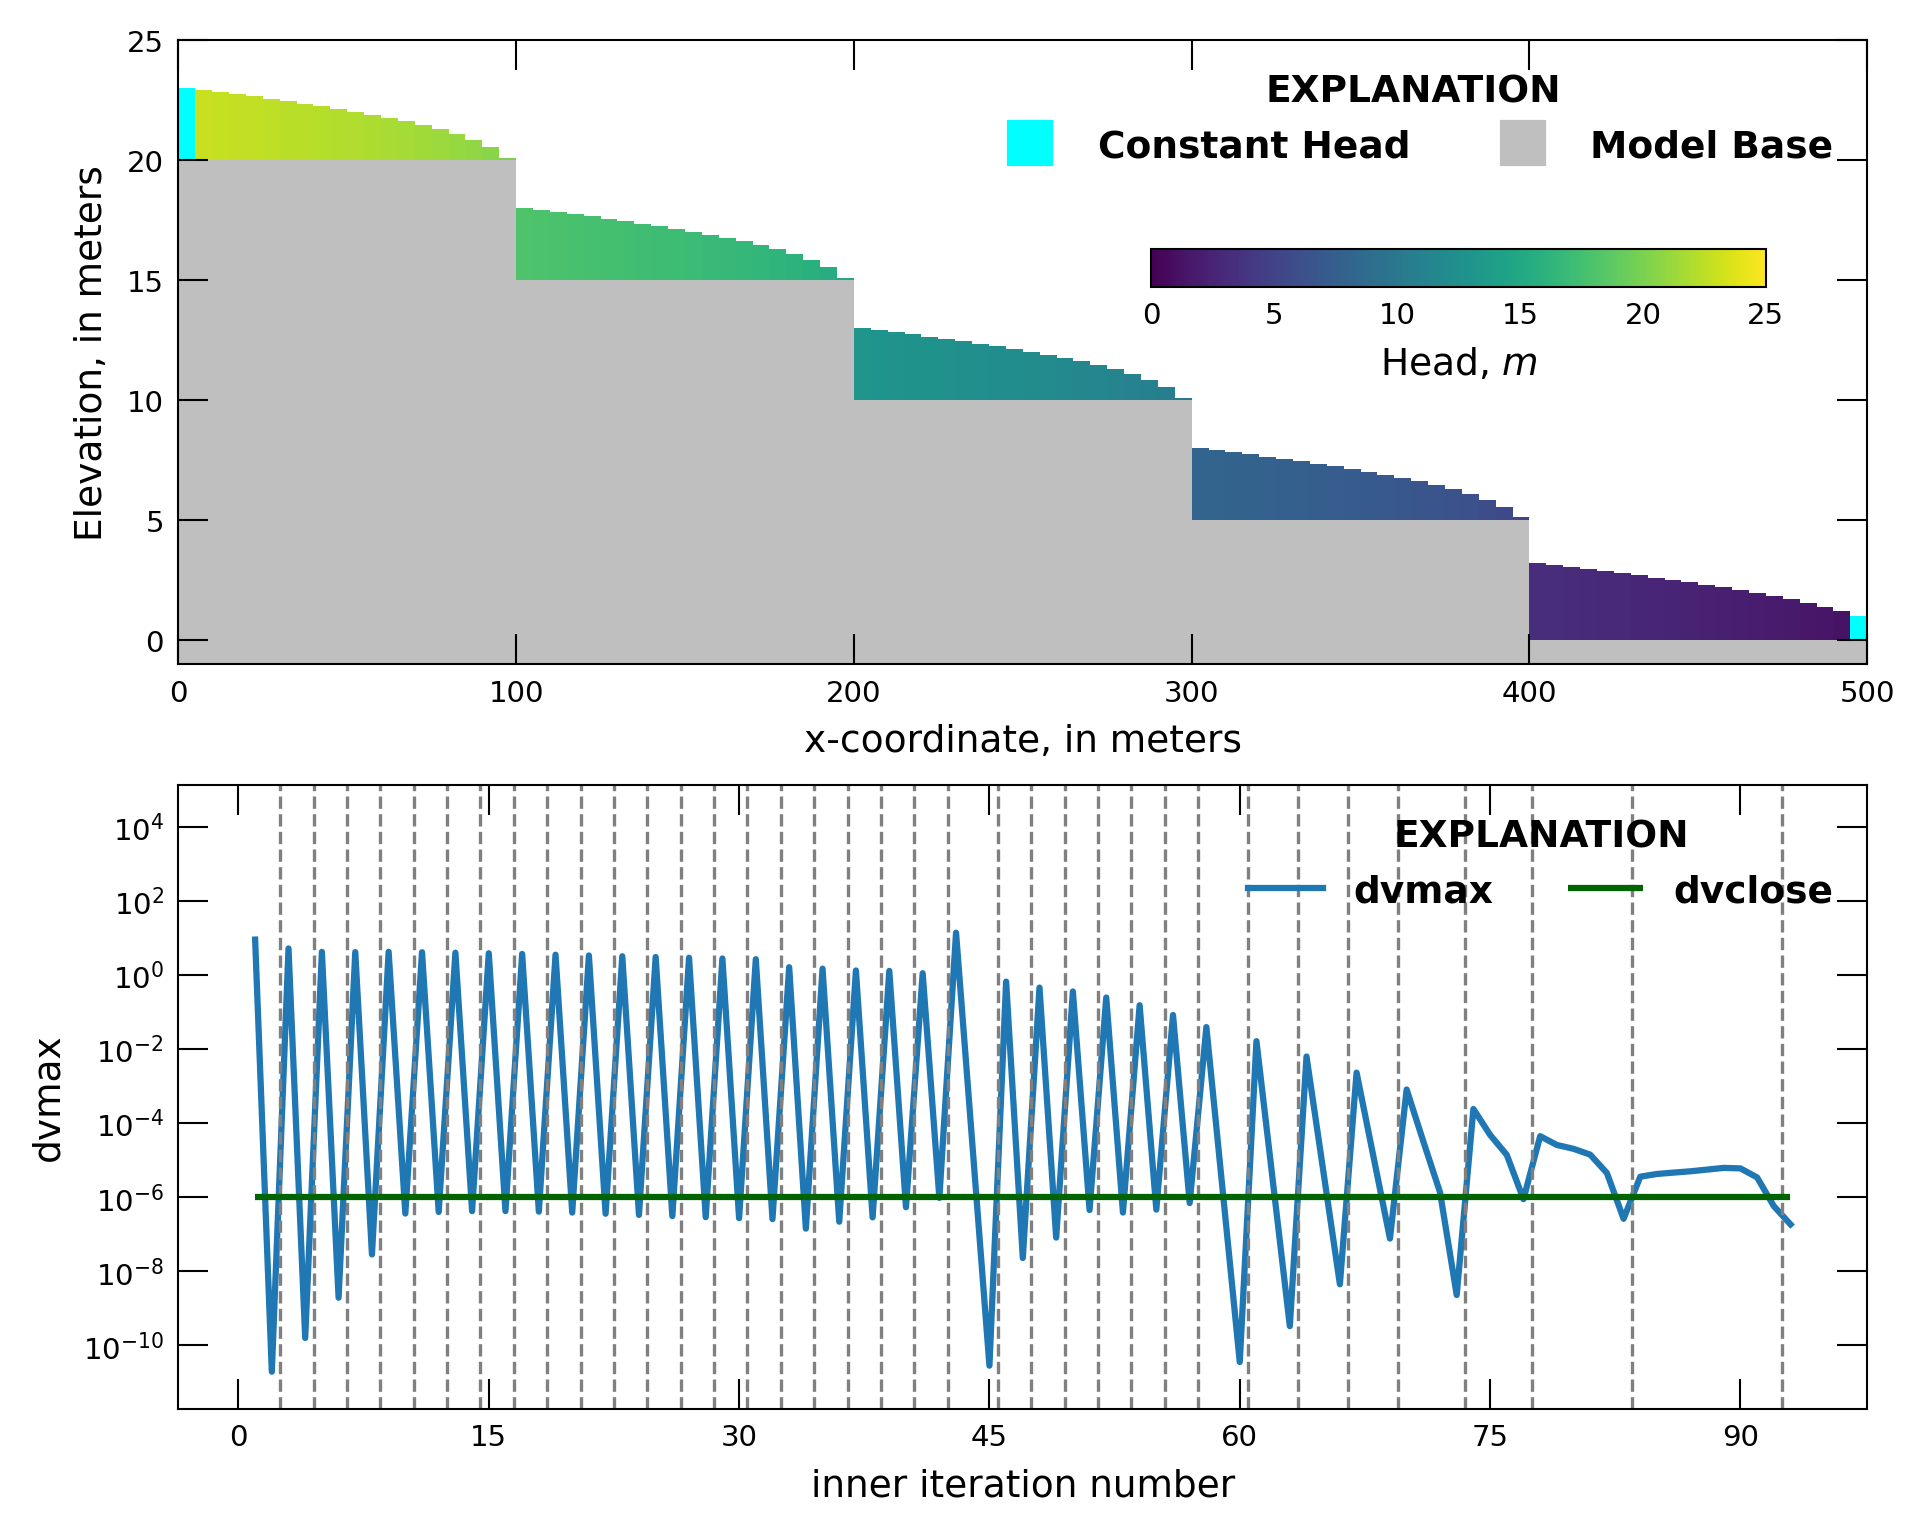

In [21]:
success = save_and_run(sim)
if success:
    plot_results(sim, False)

In [22]:
# set complexity to complex (and unset CG)
sim.ims.linear_acceleration = "bicgstab"
sim.ims.complexity = None

run succeeded...


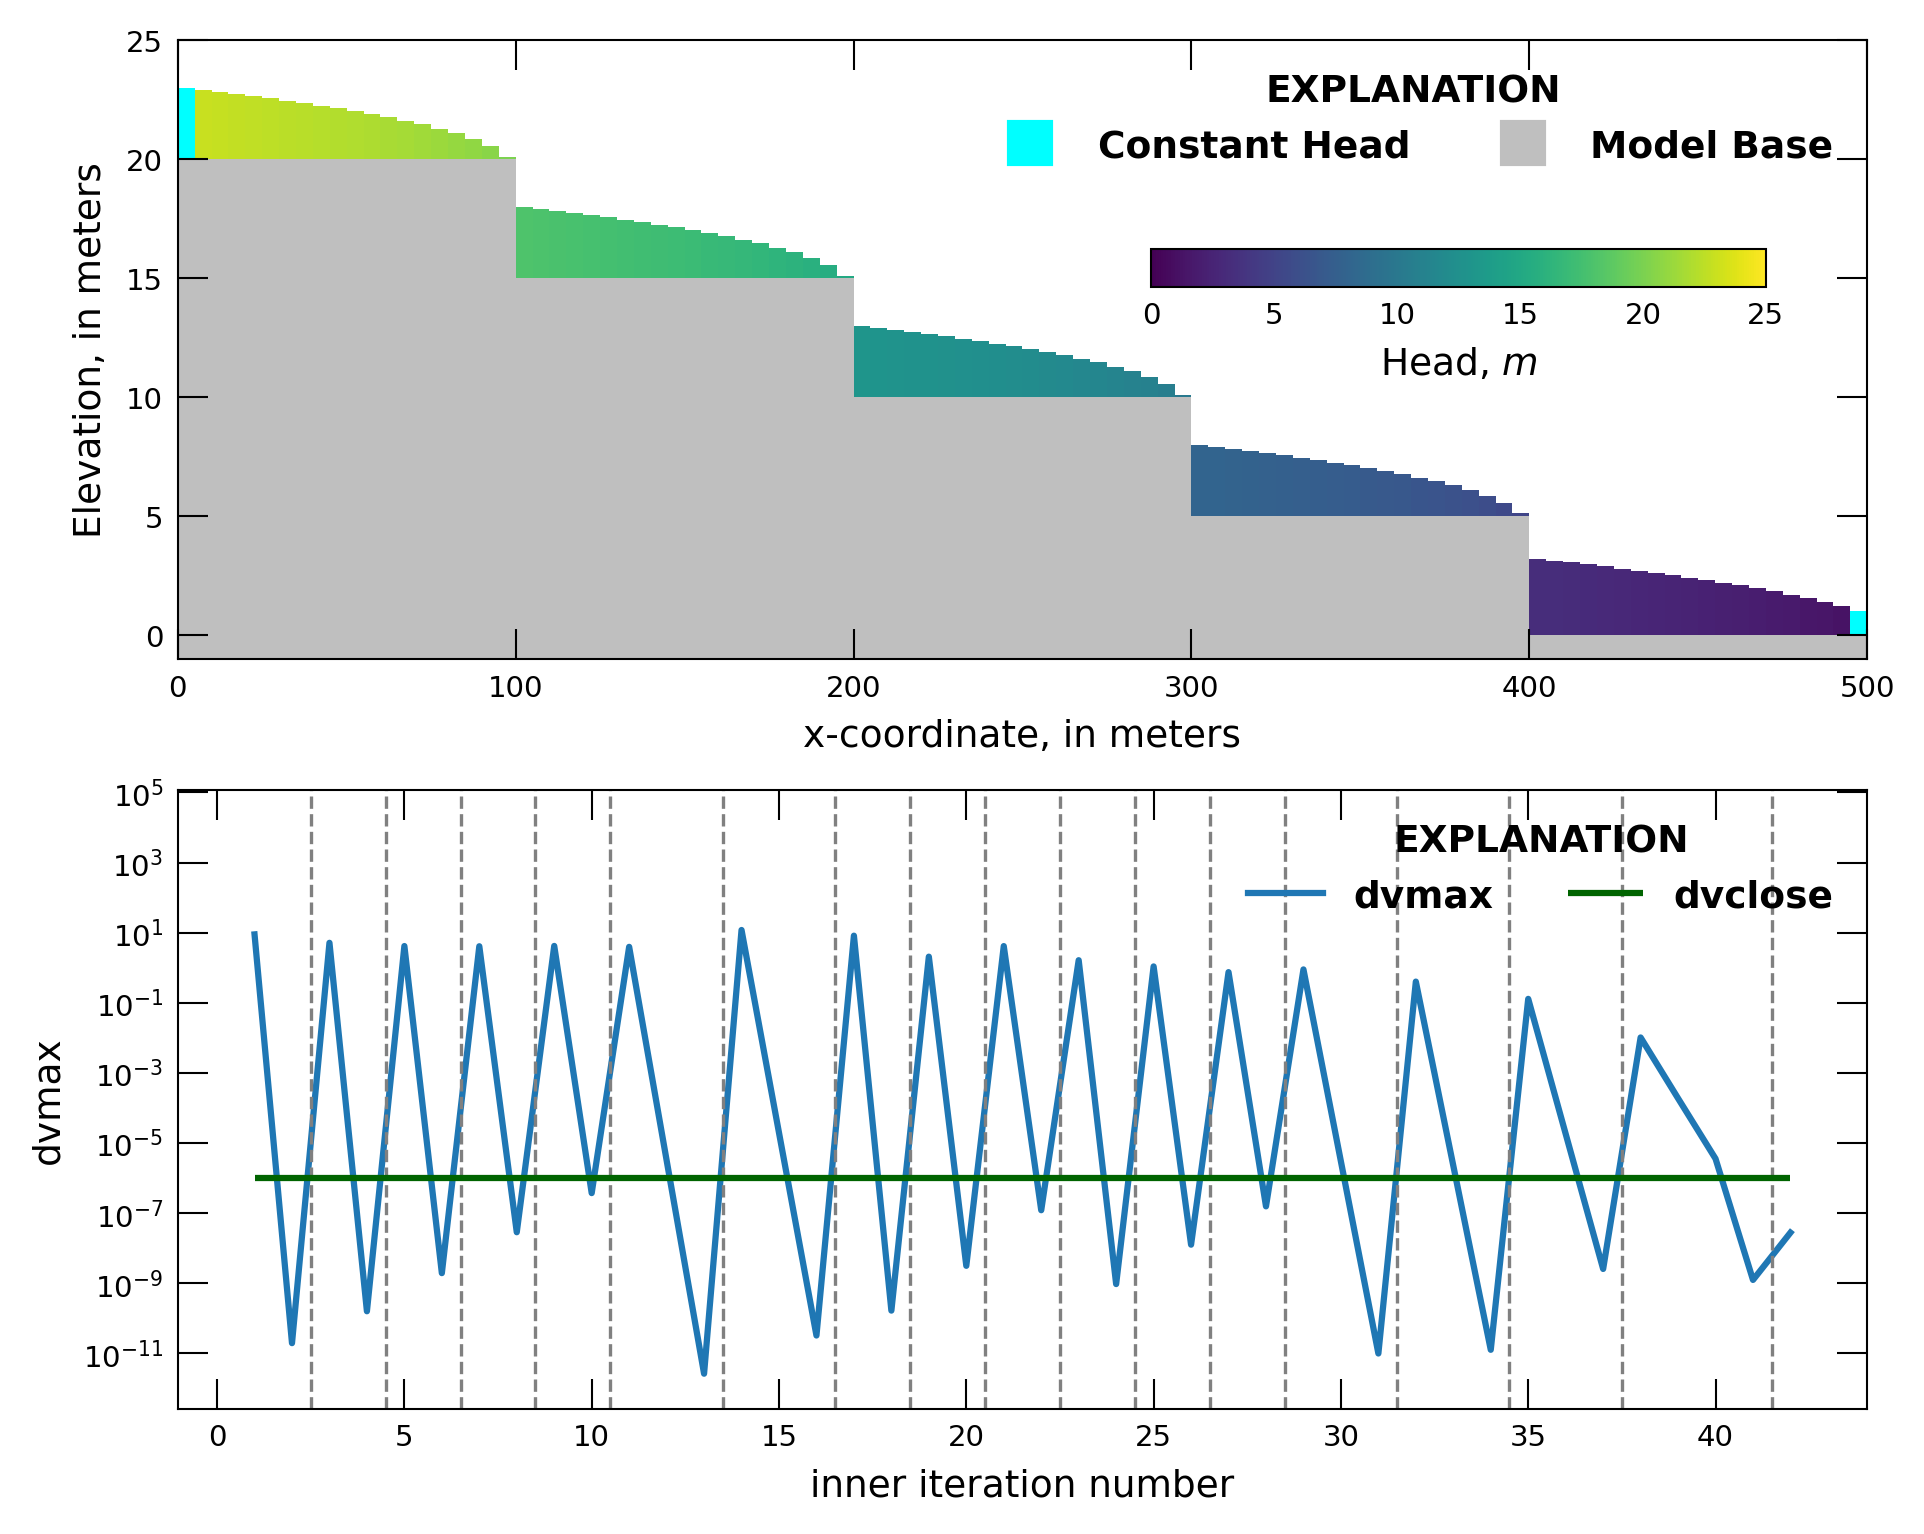

In [23]:
success = save_and_run(sim)
if success:
    plot_results(sim, False)